# Recommender Systems


In the Recommender Systems course, we were tasked with building a music recommendation system. Our data was sourced from the Kaggle competition at https://www.kaggle.com/c/dsg17-online-phase/.

The objective was to employ a recommender system to estimate the likelihood of a song being listened to by a specific user. Initially, we delved into the dataset for deeper insights. Subsequently, we experimented with various recommender models and assessed their effectiveness. Finally, we chose and refined a model with the aim of competing for the top spot.

## 1. Loading the Libraries

In [ ]:

import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from matplotlib import pyplot as plt

from surprise import Reader, Dataset, SVD as sp_SVD, KNNBasic, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score as sk_precision_score, recall_score as sk_recall_score, f1_score as sk_f1_score
from sklearn.metrics import mean_squared_error as sk_mean_squared_error





## 2. Loading the Dataset

### Data Source  


https://www.kaggle.com/c/dsg17-online-phase/

### Data fields


* media_id: identifiant of the song listened by the user
* album_id: identifiant of the album of the song
* media_duration: duration of the song
* user_gender: gender of the user
* user_id: anonymized id of the user
* context_type: type of content where the song was listened: playlist, album ...
* release_date: release date of the song with the format YYYYMMDD
* ts_listen: timestamp of the listening in UNIX time
* platform_name: type of operating system
* platform_family: type of device
* user_age: age of the user
* listen_type: if the songs was listened in a flow or not
* artist_id: identifiant of the artist of the song
* genre_id: identifiant of the genre of the song

Variable of Interest

* is_listened: 1 if the track was listened, 0 otherwise

In [ ]:
# Load Data
def load_data(filepath):
    df = pd.read_csv(filepath).sample(frac=0.1)  # Take only 10% of data for fast execution
    return df

df = pd.read_csv("/Users/elals/Downloads/train.csv", encoding='latin-1')
df.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
0,25471,1480597215,222606,41774,12,20040704,1,0,223,0,0,9241,55164,29,0
1,25571,1480544735,250467,43941,0,20060301,2,1,171,0,0,16547,55830,30,1
2,16,1479563953,305197,48078,1,20140714,2,1,149,1,1,7665,2704,29,1
3,7,1480152098,900502,71521,0,20001030,0,0,240,0,1,1580,938,30,0
4,7,1478368974,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1


## 3. Data Transformation

In [ ]:
# Information about data types

df.isna().sum()



genre_id           0
ts_listen          0
media_id           0
album_id           0
context_type       0
release_date       0
platform_name      0
platform_family    0
media_duration     0
listen_type        0
user_gender        0
user_id            0
artist_id          0
user_age           0
is_listened        0
dtype: int64

### release_date

The "release_date" variable presented an anomaly, as it held a date set in the year 3000, which was obviously unrealistic. To rectify this, we needed to substitute it with the last date that was within a plausible range before this outlier.

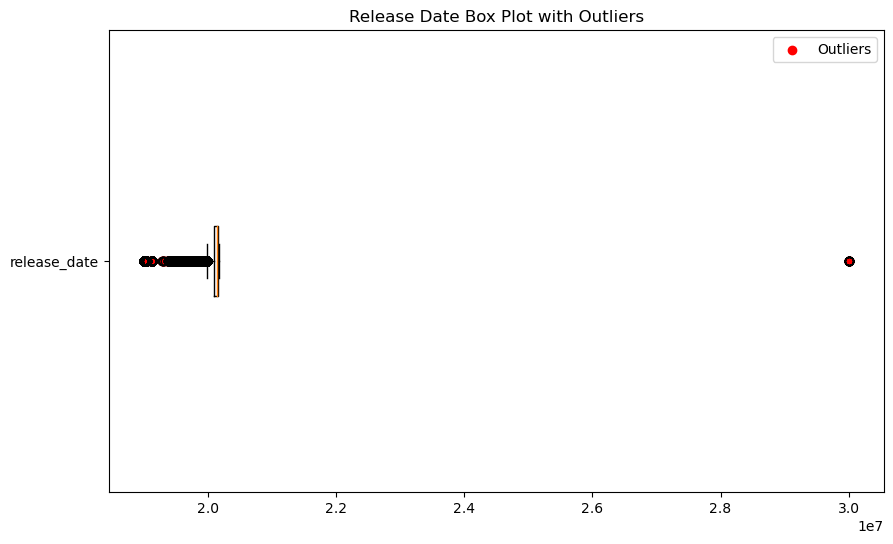

In [ ]:
# Boxplot
Q1 = df['release_date'].quantile(0.25)
Q3 = df['release_date'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['release_date'] < lower_bound) | (df['release_date'] > upper_bound)]

# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(df['release_date'], vert=False, labels=['release_date'])
plt.scatter(outliers['release_date'], [1] * len(outliers), color='red', label='Outliers')
plt.title('Release Date Box Plot with Outliers')
plt.legend()
plt.show()


### media_Id

In [ ]:
# Number of unique songs
print(f'There are {df.media_id.nunique()} different songs in the dataset.')
df['media_id'] = df['media_id'].astype("category")

There are 452975 different songs in the dataset.


### genre_id

In [ ]:
# Number of unique genres
print(f'There are {df.genre_id.nunique()} different genres in the dataset.')

# Convert genre_id a categorical variable
df['genre_id'] = df['genre_id'].astype("category")

There are 2922 different genres in the dataset.


### user_gender

In [ ]:
print(f'There are {df.user_gender.nunique()} different user genders in the dataset.')

# Convert user_gender a categorical variable
df['user_gender'] = df['user_gender'].astype("category")

There are 2 different user genders in the dataset.


### album_id

In [ ]:
# Number of unique albums
print(f'There are {df.album_id.nunique()} different albums in the dataset.')
df['album_id'] = df['album_id'].astype("category")

There are 151471 different albums in the dataset.


### platform_name

In [ ]:
# Number of unique platforms
print(f'There are {df.platform_name.nunique()} different platforms in the dataset.')

# Convert platform_name a categorical variable
df['platform_name'] = df['platform_name'].astype("category")

There are 3 different platforms in the dataset.


### platform_family

In [ ]:
# Number of unique platform families
print(f'There are {df.platform_family.nunique()} different platform families in the dataset.')
# the meanings of the numbers are unknown

# Convert platform_family a categorical variable
df['platform_family'] = df['platform_family'].astype("category")

There are 3 different platform families in the dataset.


### listen_type

In [ ]:
print(f'There are {df.listen_type.nunique()} different listen types in the dataset.')


# Convert listen_type a categorical variable
df['listen_type'] = df['listen_type'].astype("category")

There are 2 different listen types in the dataset.


### user_id

In [ ]:
print(f'There are {df.user_id.nunique()} different users in the dataset.')

# Convert user_id a categorical variable
df['user_id'] = df['user_id'].astype("category")

There are 19918 different users in the dataset.


### artist_id

In [ ]:
print(f'There are {df.artist_id.nunique()} different artists in the dataset.')

# Convert artist_id a categorical variable
df['artist_id'] = df['artist_id'].astype("category")

There are 67142 different artists in the dataset.


### is_listened

In [ ]:
print(f'The target variable "is_listened" takes {df.is_listened.nunique()} different values.')

# Convert is_listened a categorical variable
df['is_listened'] = df['is_listened'].astype("category")

The target variable "is_listened" takes 2 different values.


# 4. Exploratory Analysis

## Size of the Dataset

In [ ]:
# Total number of records
len(df)

7558834

There are over 7.5 million songs in the train dataset.

## Users

### Age

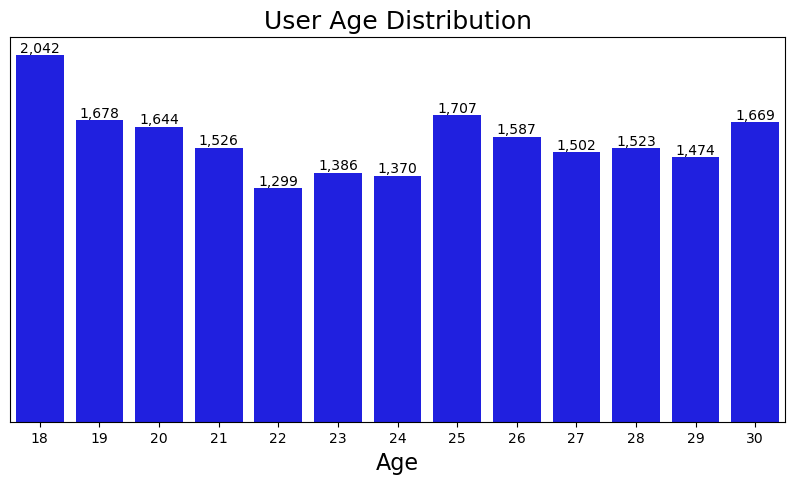

In [ ]:
# Select and aggregate data and plot results

def aggregate_user_age(df):
    usr_age_agg = df[['user_id', 'user_age']].groupby('user_age').nunique().reset_index()
    return usr_age_agg

def plot_user_age_distribution(user_age_data):
    plt.figure(figsize=(10,5))
    gph = sns.barplot(x='user_age', y='user_id', data=user_age_data, color='blue')

    plt.xlabel("Age", size=16)
    plt.ylabel("Number of Users", size=16)
    plt.title("User Age Distribution", size=18)

    ax = plt.gca()
    ax.get_yaxis().set_visible(False)

    for bar in gph.patches:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{int(bar.get_height()):,}', ha='center', va='bottom',
                 size=10, color='black')

    plt.show()

# Usage
usr_age_data = aggregate_user_age(df)
plot_user_age_distribution(usr_age_data)


### Gender

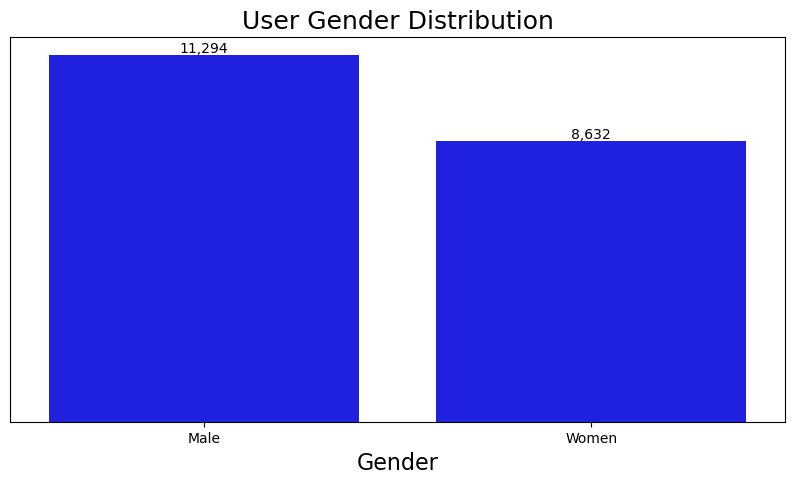

In [ ]:
# Select and aggregate data and plot results
def aggregate_user_gender(df):
    usr_gender_agg = df[['user_id', 'user_gender']].groupby('user_gender').nunique().reset_index()
    return usr_gender_agg

def plot_user_gender_distribution(user_gender_data):
    plt.figure(figsize=(10,5))
    gph = sns.barplot(x='user_gender', y='user_id', data=user_gender_data, color='blue')

    plt.xlabel("Gender", size=16)
    plt.ylabel("Number of Users", size=16)
    plt.title("User Gender Distribution", size=18)

    ax = plt.gca()
    ax.get_yaxis().set_visible(False)

    gph.set_xticklabels(('Male', 'Women'))  # Change labels (0, 1 -> Man, Woman)

    for bar in gph.patches:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{int(bar.get_height()):,}', ha='center', va='bottom',
                 size=10, color='black')

    plt.show()

# Usage
usr_gender_data = aggregate_user_gender(df)
plot_user_gender_distribution(usr_gender_data)


### Number of Users Per Weekday

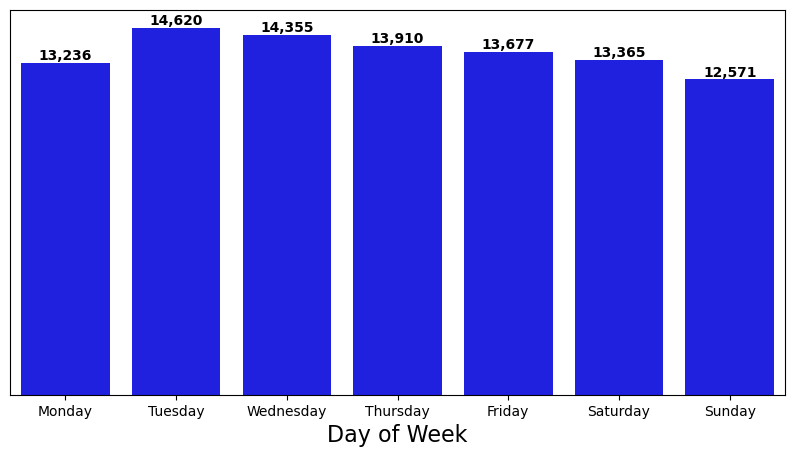

In [ ]:
# Select and aggregate data and plot results
def plot_weekday_user_count(df):
    # Select and aggregate data
    user_counts_by_weekday = df[['day_of_week', 'user_id']].groupby('day_of_week').nunique().reset_index()

    # Plot results
    plt.figure(figsize=(10,5))
    gph = sns.barplot(x='day_of_week', y='user_id', data=user_counts_by_weekday, color='blue')

    # Add labels
    plt.xlabel("Day of Week", size=16)
    plt.ylabel("Number of Users", size=16)

    # Disable Y-axis
    ax = plt.gca()
    ax.get_yaxis().set_visible(False)

    # Change labels (0,1,2,3,4,5,6 -> Monday, Tuesday, ...)
    gph.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

    # Add total per bar
    for bar in gph.patches:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{int(bar.get_height()):,}', ha='center', va='bottom',
                 size=10, color='black', weight='bold')

    plt.show()

# Usage
df['ts_listen'] = pd.to_datetime(df['ts_listen'], unit='s')
df['day_of_week'] = df['ts_listen'].dt.dayofweek

plot_weekday_user_count(df)


### Listening Time

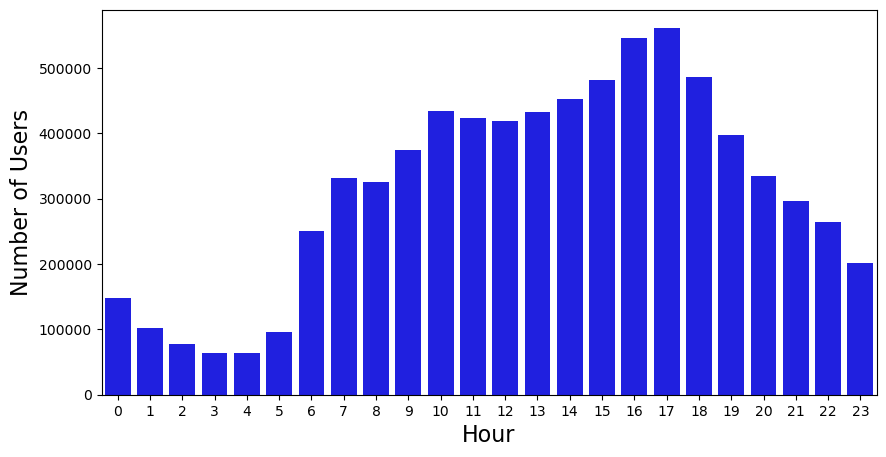

In [ ]:
# Select and aggregate data and plot results
def plot_hourly_user_count(data):
    # Extract and categorize hour listened
    data['hour_listened'] = data['ts_listen'].dt.hour
    data['hour_listened'] = data['hour_listened'].astype('category')

    # Select and aggregate data
    hourly_user_counts = data[['hour_listened', 'user_id']].groupby('hour_listened').count().reset_index()

    # Plot results
    plt.figure(figsize=(10,5))
    gph = sns.barplot(x='hour_listened', y='user_id', data=hourly_user_counts, color='blue')

    # Add labels
    plt.xlabel("Hour", size=16)
    plt.ylabel("Number of Users", size=16)

    plt.show()

df['ts_listen'] = pd.to_datetime(df['ts_listen'], unit='s')

plot_hourly_user_count(df)


### Music Duration

In [ ]:
# Minimum duration
min_duration = df['media_duration'].min()
print(f'Minimum duration: {min_duration}')

# Maximum duration
max_duration = df['media_duration'].max()
print(f'Maximum duration: {max_duration}')

# Mean duration
mean_duration = round(df['media_duration'].mean(), 1)
print(f'Mean duration: {mean_duration}')

# Quartiles
quartiles = df['media_duration'].quantile(q=(0.25, 0.5, 0.75))
print(f'Quartiles: {quartiles}')


Minimum duration: 0
Maximum duration: 65535
Mean duration: 231.2
Quartiles: 0.25    196.0
0.50    222.0
0.75    254.0
Name: media_duration, dtype: float64


# 5. Data Preparation

In [ ]:
# Load the Data

# Copy the original DataFrame to a new one

new_df = df.copy()

# Convert timestamp to datetime
new_df['ts_listen'] = pd.to_datetime(new_df['ts_listen'], unit='s')

# Outlier
print(new_df['release_date'].max()) # 30000101

# Locate the final instance preceding 30000101 and substitute the most recent "plausible" date preceding this anomalous data entry.
print(sorted(list(new_df['release_date'].unique()))[-2]) # 20170313

# Age Grouping
bins = [0, 18, 25, 35, 50, 100]
labels = ['<18', '18-24', '25-34', '35-49', '50+']
new_df['age_group'] = pd.cut(new_df['user_age'], bins=bins, labels=labels, right=False)

# Artist Popularity
artist_popularity = new_df['artist_id'].value_counts().reset_index()
artist_popularity.columns = ['artist_id', 'artist_popularity']
new_df = new_df.merge(artist_popularity, on='artist_id', how='left')

# Album Popularity
album_popularity = new_df['album_id'].value_counts().reset_index()
album_popularity.columns = ['album_id', 'album_popularity']
new_df = new_df.merge(album_popularity, on='album_id', how='left')

# Genre Popularity
genre_popularity = new_df['genre_id'].value_counts().reset_index()
genre_popularity.columns = ['genre_id', 'genre_popularity']
new_df = new_df.merge(genre_popularity, on='genre_id', how='left')

# User Listening Frequency
user_listen_frequency = new_df['user_id'].value_counts().reset_index()
user_listen_frequency.columns = ['user_id', 'user_listen_frequency']
new_df = new_df.merge(user_listen_frequency, on='user_id', how='left')

# Release Year
new_df['release_year'] = new_df['release_date'].apply(lambda x: int(str(x)[:4]))

# Favorite Artist
favorite_artist = new_df.groupby('user_id')['artist_id'].apply(lambda x: x.value_counts().index[0]).reset_index()
favorite_artist.columns = ['user_id', 'favorite_artist']
new_df = new_df.merge(favorite_artist, on='user_id', how='left')

# Recent Trend
recent_trend = new_df.sort_values('ts_listen').groupby('user_id')['genre_id'].last().reset_index()
recent_trend.columns = ['user_id', 'recent_trend']
new_df = new_df.merge(recent_trend, on='user_id', how='left')

# Season of Release
new_df['release_month'] = new_df['release_date'].apply(lambda x: int(str(x)[4:6]))
seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring',
            5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
            9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}
new_df['season_of_release'] = new_df['release_month'].map(seasons)


# Album Loyalty
album_loyalty = new_df.groupby(['user_id', 'album_id'])['media_id'].count().reset_index()
album_loyalty = album_loyalty.groupby('user_id')['media_id'].mean().reset_index()
album_loyalty.columns = ['user_id', 'album_loyalty']
new_df = new_df.merge(album_loyalty, on='user_id', how='left')

# Artist Loyalty
artist_loyalty = new_df.groupby(['user_id', 'artist_id'])['media_id'].count().reset_index()
artist_loyalty = artist_loyalty.groupby('user_id')['media_id'].mean().reset_index()
artist_loyalty.columns = ['user_id', 'artist_loyalty']
new_df = new_df.merge(artist_loyalty, on='user_id', how='left')

# Assuming columns artist_popularity and album_popularity exist
new_df['artist_album_interaction'] = new_df['artist_id'] * new_df['album_id']

# Adding temporal features
new_df['ts_listen'] = pd.to_datetime(new_df['ts_listen'], unit='s')
new_df['day_of_week'] = new_df['ts_listen'].dt.dayofweek

# Omitting the first recommended track for each user
grouped = new_df.sort_values('ts_listen').groupby('user_id')
omitted_tracks = grouped.apply(lambda x: x.iloc[0]).reset_index(drop=True)
new_df = grouped.apply(lambda x: x.iloc[1:]).reset_index(drop=True)
new_df


30000101
20170313


,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,...,user_listen_frequency,release_year,favorite_artist,recent_trend,release_month,season_of_release,album_loyalty,artist_loyalty,artist_album_interaction,day_of_week
0,0,2016-11-01 06:42:11,123339574,12920172,0,20160422,0,2,316,0,...,6317,2016,400934,77,4,Spring,3.611778,5.237977,13382442833988,1
1,0,2016-11-01 06:42:41,131340580,13947748,0,20160902,0,2,224,0,...,6317,2016,400934,77,9,Autumn,3.611778,5.237977,60407752378992,1
2,0,2016-11-01 06:43:02,131576046,13976722,0,20160906,0,2,210,0,...,6317,2016,400934,77,9,Autumn,3.611778,5.237977,48485248618,1
3,0,2016-11-01 06:46:32,129011934,13640610,0,20160722,0,2,185,0,...,6317,2016,400934,77,7,Summer,3.611778,5.237977,3848261611980,1
4,0,2016-11-01 06:49:38,129632340,13726450,0,20160805,0,2,205,0,...,6317,2016,400934,77,8,Summer,3.611778,5.237977,6626553549100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7538911,7,2016-11-07 17:43:48,13277567,1216476,0,20110819,0,0,184,0,...,2,2011,6377,7,8,Summer,1.000000,1.000000,1802121607728,0
7538912,1106,2016-11-28 09:25:22,65800609,6450730,17,20130415,1,0,199,0,...,2,2013,4050205,1106,4,Spring,1.000000,1.000000,7452180029580,0
7538913,0,2016-11-26 12:31:38,132123626,14038232,3,20160916,1,0,190,0,...,2,2016,1519461,0,9,Autumn,2.000000,2.000000,21330546032952,5
7538914,27,2016-11-01 00:35:09,70227575,6888863,3,20130909,0,0,270,0,...,2,2013,11799,27,9,Autumn,1.000000,2.000000,81281694537,1
